In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error #roc_auc_score as AUC
from sklearn.externals import joblib

import pickle
import time
import os.path
import math


# Load Data

In [2]:
n_bytes = 2**31
max_bytes = 2**31 - 1

def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [3]:
train = load_pickle('train_df_after_preprocessing.pkl') # balanced class
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

#train_click = train['click']
train_click = train['click']
train_bidprice = train['bidprice']
train_payprice = train['payprice']
#train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)
train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

# GBDT+LR

In [4]:
from sklearn import metrics
# 导入数据  
# X = train.drop(['click','payprice','bidprice'], axis = 1) 
# y = train['click']
  
# 切分为测试集和训练集，比例0.5  
X_train, X_test, y_train, y_test = train_test_split(train_X, train_click, test_size=0.5)  
# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。  
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)  
  
# 弱分类器的数目  
n_estimator = 10  
# 调用GBDT分类模型  
grd = GradientBoostingClassifier(n_estimators=n_estimator)  
  
# 调用one-hot编码。  
grd_enc = OneHotEncoder()  
  
# 调用LR分类模型。  
grd_lm = LogisticRegression()  
  
#使用X_train训练GBDT模型，后面用此模型构造特征  
grd.fit(X_train, y_train)  
  
#直接进行预测，查看AUC得分  
y_pred_grd = grd.predict_proba(X_test)[:, 1]  
fpr_grd, tpr_grd, _ = metrics.roc_curve(y_test, y_pred_grd)  
roc_auc = metrics.auc(fpr_grd, tpr_grd)  
print('predict',roc_auc)  
  
# fit one-hot编码器  
grd_enc.fit(grd.apply(X_train)[:, :, 0])  
  
#使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。  
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)  
  
# 用训练好的LR模型多X_test做预测  
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]  
  
# 根据预测结果输出  
fpr_grd_lm, tpr_grd_lm, _ = metrics.roc_curve(y_test, y_pred_grd_lm)  
roc_auc = metrics.auc(fpr_grd_lm, tpr_grd_lm)  
print('predict',roc_auc)
  
print("AUC Score :",(metrics.roc_auc_score(y_test, y_pred_grd_lm)))    

y_pred_grd_lm

predict 0.784644243691
predict 0.785640958638
AUC Score : 0.785640958638


array([ 0.23895859,  0.85200175,  0.37068751, ...,  0.23895859,
        0.37068751,  0.37068751])

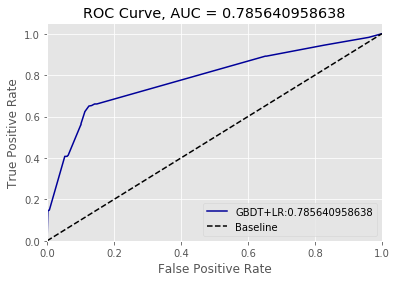

In [5]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots()
    ax.plot(fpr_grd_lm, tpr_grd_lm, "#000099", label='GBDT+LR:'+str(roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve, AUC = '+str(roc_auc))

In [6]:
joblib.dump(grd_lm, 'GBDT+LR' + ".pickle.dat" )

['GBDT+LR.pickle.dat']

In [7]:
model = joblib.load("GBDT+LR.pickle.dat")
valid_ctr_prediction=model.predict_proba(grd_enc.transform(grd.apply(valid_X)[:, :, 0]))[:, 1]  

# Prediction

In [8]:
def LinearBidding(pCTR, basePrice, avgCTR):
    return basePrice*pCTR/avgCTR

In [9]:
def EvaluateClick( pCTR, budget, base_price, avg_CTR, valid_payprice, valid_click):
    
    bid_price = LinearBidding(pCTR, base_price, avg_CTR)
    auction = bid_price >= valid_payprice
    win_bid_ix = [index for index, auction in enumerate(auction) if auction]

    clicks = sum(valid_click[win_bid_ix])
    spend = sum(valid_payprice[win_bid_ix])

    sorted_pCTR_index = sorted(range(len(pCTR)), key=lambda k: pCTR[k])

    if spend > budget:
        print('overspend')
        for bid_id in sorted_pCTR_index:

            spend -= valid_bidprice[bid_id]
            clicks -= valid_click[bid_id]

            if spend <= budget:
                break

    print('spend:', spend, ' click:', clicks)
    return spend,clicks

EvaluateClick( valid_ctr_prediction, 6250000, 5, 0.0007, valid_payprice, valid_click)

overspend
spend: 6249873  click: 190


(6249873, 190)

In [10]:
# search the best base_price
base_prices = [0.001, 0.01, 0.1, 1, 10, 100,1000]
spend = []
clicks = []

for base in base_prices:
    print(base)
    s,c = EvaluateClick( valid_ctr_prediction, 6250000, base, 0.0007, valid_payprice, valid_click)
    spend.append(s)
    clicks.append(c)

0.001
spend: 28  click: 0
0.01
spend: 28990  click: 4
0.1
spend: 3832917  click: 103
1
overspend
spend: 6249813  click: 190
10
overspend
spend: 6249873  click: 190
100
overspend
spend: 6249873  click: 190
1000
overspend
spend: 6249873  click: 190


In [11]:
### prediction
#valid_ctr_prediction=model.predict_proba(grd_enc.transform(grd.apply(valid_X)[:, :, 0]))[:, 1]  
test_prediction = model.predict_proba(grd_enc.transform(grd.apply(test)[:, :, 0]))[:, 1]

budget = 6250000
base_price = 10
bid_price = base_price*test_prediction/0.0007
sorted_pCTR_index = sorted(range(len(bid_price)), key=lambda k: bid_price[k])
spend = sum(bid_price)

if spend > budget:
    print('overspend')
    for bid_id in sorted_pCTR_index:

        spend -= bid_price[bid_id]
        bid_price[bid_id] = 0
        
        if spend <= budget:
            break

print('spend:', spend)


submission = pd.read_csv('Group_xx.csv')
submission['bidprice'] = bid_price
submission.to_csv('Group_9.csv')

overspend
spend: 6237975.4426


In [12]:
test_prediction

array([ 0.7241061 ,  0.7836689 ,  0.2341012 , ...,  0.2341012 ,
        0.85200175,  0.35308937])